In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2
from typing import List, Tuple
import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import wandb
from time import time
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print("begin")

begin


In [4]:
sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')
import segmentation_models_pytorch as smp

/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:255: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if block_type is 'proj':
/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:258: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif block_type is 'down':
/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels/models/dpn.py:262: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert block_type is 'normal'


In [5]:
class CFG:
    seed = 1337
    comp_name = 'vesuvius'
    mode = "test"  # 'test'  # "train"

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'  # 'se_resnext50_32x4d'
    model_to_load = None  # '../model_checkpoints/vesuvius_notebook_clone_exp_holdout_3/models/Unet-zdim_6-epochs_30-step_15000-validId_3-epoch_9-dice_0.5195_dict.pt'
    target_size = 1
    in_chans = 6  # 6  # 65
    pretrained = True
    inf_weight = 'best'
    TTA = False
    model_paths = [
    '/kaggle/input/vesuvius-model/Unet-zdim_6-epochs_13-step_15000-validId_1-epoch_4-dice_0.4736_dict.pt',
    '/kaggle/input/vesuvius-model/Unet-zdim_6-epochs_10-step_15000-validId_3_dict_final.pt'
    ]

    # ============== training cfg =============
    epochs = 50  # 15 # 30
    train_steps = 15000
    size = 224  # Size to shrink image to
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 64
    valid_batch_size = train_batch_size * 3
    valid_id = 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'  # 'CosineAnnealingLR'
    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    num_workers = 0

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # adamW warmup
    warmup_factor = 10
    lr = 1e-4 / warmup_factor

    # ============== Experiment cfg =============
    # ToDO consolidate these names into one
    exp_name = f'vesuvius_notebook_clone_exp_holdout_{valid_id}'
    EXPERIMENT_NAME = f"{model_name}-zdim_{in_chans}-epochs_{epochs}-step_{train_steps}-validId_{valid_id}"

    # ============== Inference cfg =============
    THRESHOLD = 0.3  # .52 score had a different value of .25

    # ============== set dataset paths =============
    comp_dir_path = '/kaggle/input/vesuvius-challenge-ink-detection/'  # '../'
    comp_dataset_path = comp_dir_path
    outputs_path = comp_dir_path + f'model_checkpoints/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'
    model_dir = outputs_path + 'models/'
    figures_dir = outputs_path + 'figures/'

    # ============== Augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
            A.GaussNoise(var_limit=[10, 50]),
            A.GaussianBlur(),
            A.MotionBlur(),
        ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

In [6]:
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_fast(img, threshold):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formatted
    """
    pixels = img.flatten()
    pixels = (pixels >= threshold) #.astype(int)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Dataset

In [7]:
class TestImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image

In [8]:
def read_image_and_labels(fragment_id: str, is_train: bool = True, mode: str = "train"):
    images = []

    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    print(f'Tif file example: {CFG.comp_dataset_path}{mode}/{fragment_id}/surface_volume/10.tif')
    for i in tqdm(idxs):
        file_name = CFG.comp_dataset_path + f"{mode}/{fragment_id}/surface_volume/{i:02}.tif"
#         print(f"File name is {file_name}")
        image = cv2.imread(file_name, 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)  # Shape: (8288, 6496, 6)

    print(f"Length of image stack: {images.size}")
    if is_train:
        labels = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
        labels = np.pad(labels, [(0, pad0), (0, pad1)], constant_values=0)

        labels = labels.astype('float32')
        labels /= 255.0  # Normalizing?
    else:
        labels = None

    return images, labels


def make_test_dataset(frag_id: str):
    test_images, _ = read_image_and_labels(frag_id, is_train=False, mode='test')

    x1_list = list(range(0, test_images.shape[1]-CFG.tile_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.tile_size+1, CFG.stride))

    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        y2 = y1 + CFG.tile_size
        for x1 in x1_list:
            x2 = x1 + CFG.tile_size

            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
    
    test_dataset = TestImageDataset(test_images_list, transform=get_transforms(data='valid', cfg=CFG))

    test_loader = DataLoader(test_dataset,
                             batch_size=CFG.valid_batch_size,
                             shuffle=False,
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    return test_loader, xyxys


def get_transforms(data, cfg):
    return A.Compose(cfg.train_aug_list) if data == 'train' else A.Compose(cfg.valid_aug_list)

In [9]:
#  Code to test that above loader works. pathing and such
# test_loader, xyxys = make_test_dataset('a')

# Model

In [10]:
class CustomModel(nn.Module):
    """
    Model from the public kaggle .41 scoring submission. Which goes up to .52 with TTA
    """
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone,
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        output = output.squeeze(-1)  # was un commented in inference model
        return output


def build_model(cfg, weight="imagenet"):
    print(f'model_name: {cfg.model_name}')
    print(f'backbone: {cfg.backbone}')

    model = CustomModel(cfg, weight)

    return model

In [11]:
class EnsembleModel(nn.Module):
    def __init__(self, paths: List):
        super().__init__()
        self.model = nn.ModuleList()
        for path in paths:
            print(path)
            _model = CustomModel(CFG)
            _model.load_state_dict(torch.load(path))
            _model.eval()
            self.model.append(_model)
    
    def forward(self,x):
        output=[]
        for m in self.model:
            output.append(m(x))
        output=torch.stack(output,dim=0).mean(0)
        return output


def TTA(x:torch.Tensor, model:nn.Module):
    #x.shape=(batch,c,h,w)
    if CFG.TTA:
        shape=x.shape
        x=[x,*[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(1,4)]]
        x=tc.cat(x,dim=0)
        x=model(x)
        x=torch.sigmoid(x)
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0)
        return x.mean(0)
    else :
        x=model(x)
        x=torch.sigmoid(x)
        return x

In [13]:
model = EnsembleModel(CFG.model_paths)
# model = nn.DataParallel(model, device_ids=[0])
model = model.cuda()

/kaggle/input/vesuvius-model/Unet-zdim_6-epochs_13-step_15000-validId_1-epoch_4-dice_0.4736_dict.pt
/kaggle/input/vesuvius-model/Unet-zdim_6-epochs_10-step_15000-validId_3_dict_final.pt


In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is: {DEVICE}')
# model = CustomModel(CFG)
# model.to(DEVICE)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of model params is: {num_params:,}")

Device is: cuda
Number of model params is: 12,504,666


In [20]:
# model_path = '/kaggle/input/vesuvius-model/Unet-zdim_6-epochs_13-step_15000-validId_1-epoch_4-dice_0.4736_dict.pt'
# model_path = '/kaggle/input/vesuvius-model/Unet-zdim_6-epochs_10-step_15000-validId_3_dict_final.pt'
# model.load_state_dict(torch.load(model_path))

In [21]:
model.eval()
print("Eval mode")

Eval mode


# Do the Inference

In [22]:
fragment_ids = sorted(os.listdir(CFG.comp_dataset_path + 'test'))
print(f"Testing fragment Ids: {fragment_ids}")

Testing fragment Ids: ['a', 'b']


Inferring for a
Tif file example: /kaggle/input/vesuvius-challenge-ink-detection/test/a/surface_volume/10.tif


  0%|          | 0/6 [00:00<?, ?it/s]

Length of image stack: 113498112


Inference Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Inference for fragment a took 12.063 seconds or 0.201 mins
mask_count_min: 1.0


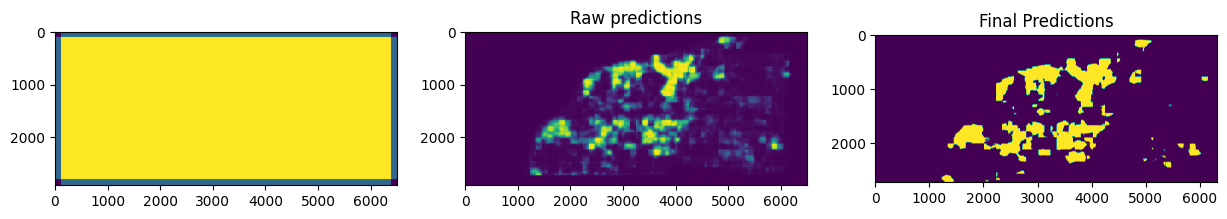

Inferring for b
Tif file example: /kaggle/input/vesuvius-challenge-ink-detection/test/b/surface_volume/10.tif


  0%|          | 0/6 [00:00<?, ?it/s]

Length of image stack: 218265600


Inference Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Inference for fragment b took 17.865 seconds or 0.2978 mins
mask_count_min: 1.0


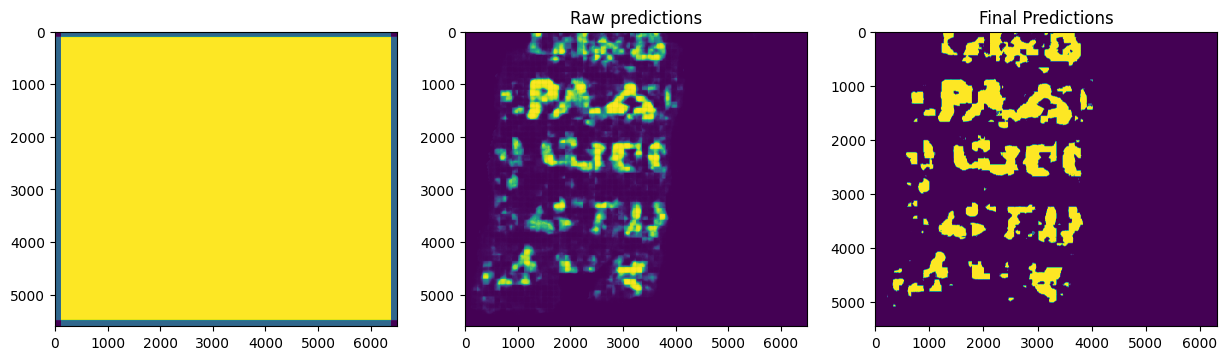

Inference over. Assemble submission dataframe


In [23]:
results = []
for fragment_id in fragment_ids:
    print(f"Inferring for {fragment_id}")
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(CFG.comp_dataset_path + f"{CFG.mode}/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)

    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.tile_size - binary_mask.shape[0] % CFG.tile_size)
    pad1 = (CFG.tile_size - binary_mask.shape[1] % CFG.tile_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask_pred = np.zeros(binary_mask.shape, dtype=float)  # Kaggle didn't have the dtype arg.
    mask_count = np.zeros(binary_mask.shape, dtype=float)

    initial = time()
    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference Batches'):
        images = images.to(DEVICE)
        batch_size = images.size(0)

        with torch.no_grad():
            y_preds = TTA(images,model).cpu().numpy()
#             y_preds = model(images)
#             y_preds = torch.sigmoid(y_preds).to('cpu').numpy()  # Wasn't in the original code here.
            # y_pred = TTA(images,model).cpu().numpy()  From TTA

        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            # mask_pred[y1:y2, x1:x2] += y_preds[i].reshape(mask_pred[y1:y2, x1:x2].shape) From TTA
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    final = time()
    total = final - initial
    print(f"Inference for fragment {fragment_id} took {total:.5} seconds or {total/60:.4} mins")
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count

    # Setup plot for the graphs
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    axes[0].imshow(mask_count)
    axes[1].set_title("Mask")
    axes[1].imshow(mask_pred.copy())
    axes[1].set_title("Raw predictions")

    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]

    mask_pred = (mask_pred >= CFG.THRESHOLD).astype(int)
    mask_pred *= binary_mask

    axes[2].imshow(mask_pred)
    axes[2].set_title('Final Predictions')
    plt.show()

#     inklabels_rle = rle(mask_pred, CFG.THRESHOLD)
    inklabels_rle = rle_fast(mask_pred, CFG.THRESHOLD)
    results.append((fragment_id, inklabels_rle))

    del mask_pred, mask_count
    del test_loader

    gc.collect()
    torch.cuda.empty_cache()
#     break  # todo remove this before submitting!
print("Inference over. Assemble submission dataframe")

# Create Submission CSV

In [24]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
sample_sub = pd.read_csv(CFG.comp_dataset_path + 'sample_submission.csv')
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
sample_sub

,Id,Predicted
0,a,650593 8 656879 11 656891 1 656895 2 656899 7 ...
1,b,1270 187 1799 14 1814 1 1816 1 2106 11 2118 1 ...


In [25]:
sample_sub.to_csv("submission.csv", index=False)

In [26]:
df = pd.read_csv("submission.csv")
df

,Id,Predicted
0,a,650593 8 656879 11 656891 1 656895 2 656899 7 ...
1,b,1270 187 1799 14 1814 1 1816 1 2106 11 2118 1 ...
